# Importing Liberaries

In [1]:
import warnings 
warnings.filterwarnings('ignore')

#Basic packages
import os
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
from statsmodels.tsa import stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# %matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('forecast.csv')
# parse strings to datetime type
dataset['Years'] = dataset['Years'].astype(str)
# df = dataset['Years'].apply(lambda x:int(x))
# df

In [3]:
dataset.head()

,Years,production,Area,productivity
0,1970,17990,31094,578.57
1,1971,14558,28547,509.97
2,1972,12752,28614,445.66
3,1973,17509,31528,555.35
4,1974,14046,28072,500.36


In [4]:
dataset.count()

Years           50
production      50
Area            50
productivity    50
dtype: int64

In [5]:
dataset['Years'] = pd.to_datetime(dataset['Years'])
indexedDataset = dataset.set_index(['Years'])


In [6]:
indexedDataset.head()

,production,Area,productivity
Years,,,
1970-01-01,17990,31094,578.57
1971-01-01,14558,28547,509.97
1972-01-01,12752,28614,445.66
1973-01-01,17509,31528,555.35
1974-01-01,14046,28072,500.36


# Data Visualisation

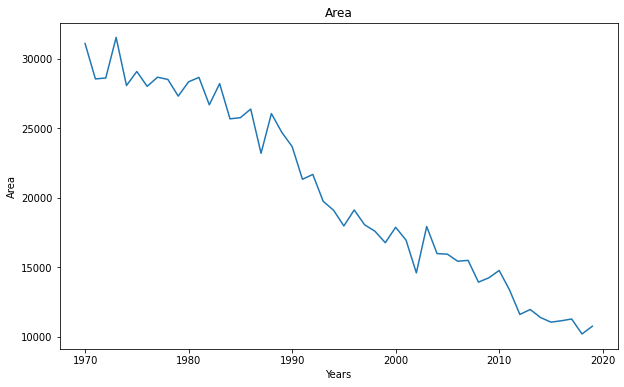

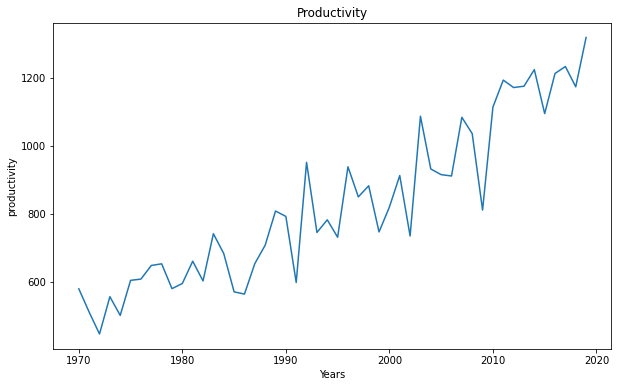

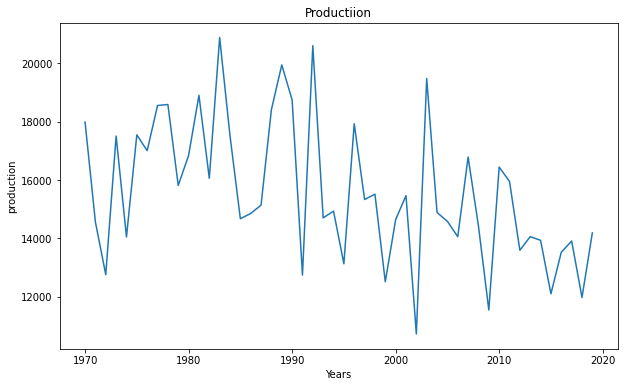

In [7]:
# draw lineplot
sns.lineplot(x="Years", y="Area", data=dataset).set(title='Area')
plt.show()
sns.lineplot(x="Years", y="productivity", data=dataset).set(title='Productivity')
plt.show()
sns.lineplot(x="Years", y="production", data=dataset).set(title='Productiion')
plt.show()

In [8]:
indexedDataset = indexedDataset.drop('production', axis=1)
indexedDataset = indexedDataset.drop('productivity', axis=1)

In [9]:
indexedDataset.head()

,Area
Years,
1970-01-01,31094
1971-01-01,28547
1972-01-01,28614
1973-01-01,31528
1974-01-01,28072


# Decomposing Time Series

<Figure size 720x432 with 0 Axes>

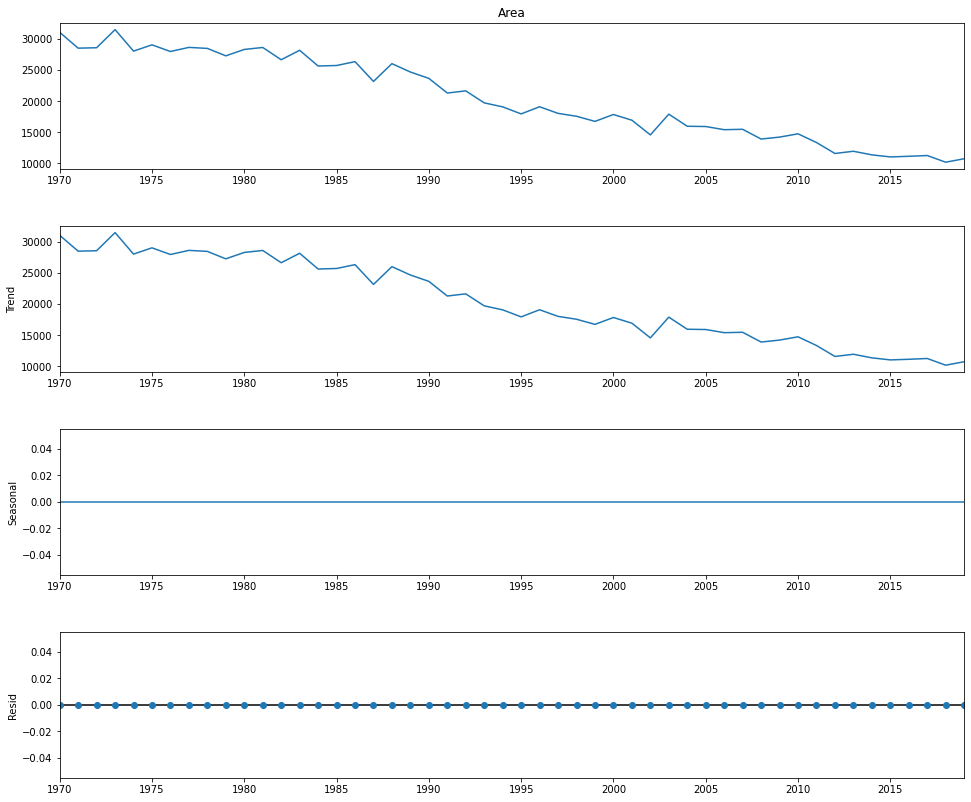

In [10]:
#Seasonal decomposition using moving averages
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(indexedDataset['Area'], model='additive', period=1)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

# Checking Stationarity

Dickey-Fuller Test
- A stationary time series is one whose properties do not depend on the time at which the series is observed.

In [11]:
def dickey_fuller_test(timeseries, window = 12, cutoff = 0.01):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
dickey_fuller_test(indexedDataset['Area'])

p-value = 0.9713. The series is likely non-stationary.
Test Statistic                  0.182816
p-value                         0.971281
#Lags Used                      2.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


- Since p value is greater than 0.05. Hence the series is non-stationary

## Converting into stationarity

p-value = 0.0000. The series is likely stationary.
Test Statistic                -9.114782e+00
p-value                        3.324985e-15
#Lags Used                     1.000000e+00
Number of Observations Used    4.700000e+01
Critical Value (1%)           -3.577848e+00
Critical Value (5%)           -2.925338e+00
Critical Value (10%)          -2.600774e+00
dtype: float64


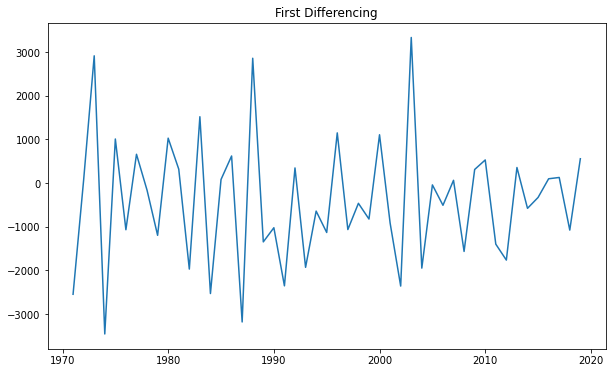

In [12]:
first_diff = indexedDataset.Area - indexedDataset.Area.shift(1)
plt.plot(first_diff)
plt.title("First Differencing")
first_diff = first_diff.dropna(inplace = False)
# print(first_diff.head())
dickey_fuller_test(first_diff, window = 12)

# Data Spliting

In [13]:
size = int(0.80*len(indexedDataset))
train_df = indexedDataset[:size]
test_df  = indexedDataset[size:]
length = len(indexedDataset)
length_train = len(train_df)
length_test = len(test_df)

In [14]:
train_df.count()

Area    40
dtype: int64

In [15]:
test_df.head()

,Area
Years,
2010-01-01,14771
2011-01-01,13372
2012-01-01,11608
2013-01-01,11964
2014-01-01,11385


Text(0.5, 1.0, 'Area')

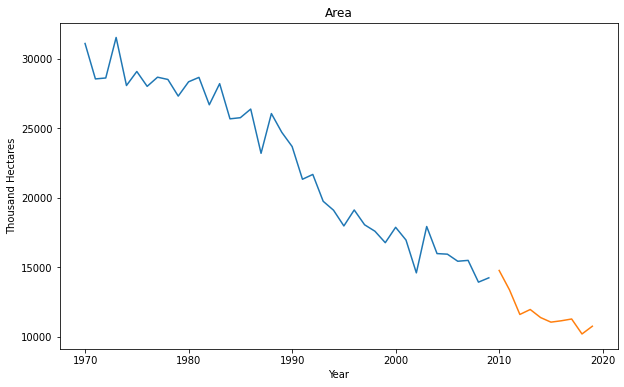

In [35]:
plt.plot(train_df)
plt.plot(test_df)
plt.xlabel('Year')
plt.ylabel('Thousand Hectares')
plt.title("Area")

# Ploting ACF and PACF

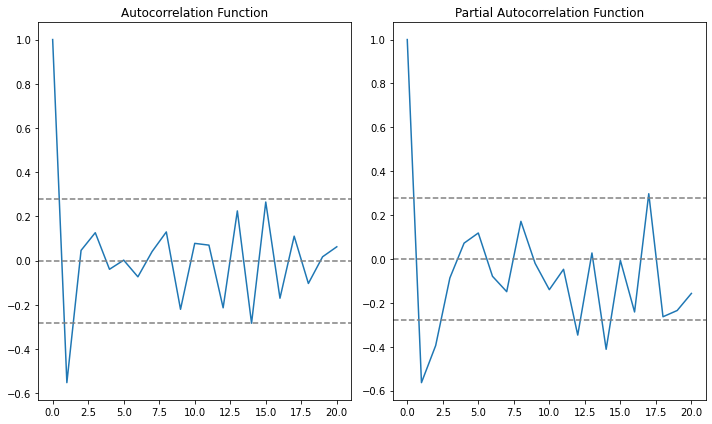

In [17]:
# an only compute partial correlations for lags up to 50% of the sample size. Hence nlag = 40//2 = 20
lag_acf = acf(first_diff,nlags=20)
lag_pacf = pacf(first_diff,nlags=20)

# The axhline() function in pyplot module of matplotlib library is used to add a horizontal line across the axis.

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray') #Formula of CI = 1.96* sqrt(n)
plt.axhline(y=1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

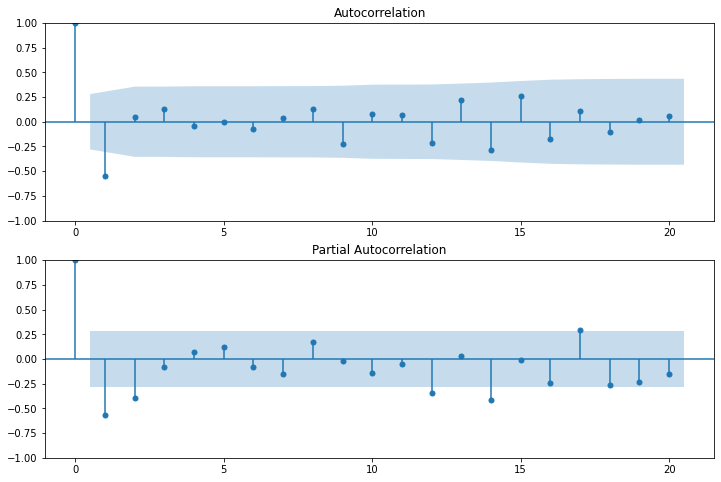

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=20, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=20, ax=ax2)

## Auto Arima for Estimating Parameters

In [19]:
from pmdarima import auto_arima

fit = auto_arima(indexedDataset, trace=True, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, 
                 start_Q=1, max_P=20, max_Q=20, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', 
                 alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True,n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=857.374, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=848.964, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=849.265, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=859.164, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=850.477, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=853.907, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=845.761, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=845.029, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=845.703, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=845.972, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=845.609, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=847.819, Time=0.0

# ARIMA Model

In [20]:
arima_model = sm.tsa.arima.ARIMA(endog = train_df, order=(3, 1, 1))
ar_model= arima_model.fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Area   No. Observations:                   40
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -335.896
Date:                Wed, 23 Nov 2022   AIC                            681.792
Time:                        11:10:10   BIC                            690.109
Sample:                    01-01-1970   HQIC                           684.776
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6226      0.403     -1.544      0.123      -1.413       0.168
ar.L2         -0.0370      0.149     -0.248      0.804      -0.330       0.256
ar.L3          0.1657      0.119      1.389      0.165      -0.068       0.399
ma.L1          0.4404      0.407      1.081      0.280      -0.358       1.239
sigma2      1.602e+06   3.77e+05      4.246      0.000    8.63e+05    2.34e+06
===================================================================================
Ljung-Box (L1) (Q):                  10.00   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.00   Prob(JB):                         0.84
Heteroskedasticity (H):               2.02   Skew:                             0.22
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The P-Value should be less than 0.05, ideally for the corresponding X to be significant.

## Forecast

In [57]:
start_index = length_train+1
end_index= length
predicted_arima = ar_model.predict(start = start_index, end = end_index)
print(predicted_arima.head())

2011-01-01    13957.246347
2012-01-01    14164.603340
2013-01-01    14038.619779
2014-01-01    14068.277048
2015-01-01    14088.823942
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [58]:
predicted_arima.to_excel('Area_arima1.xlsx')

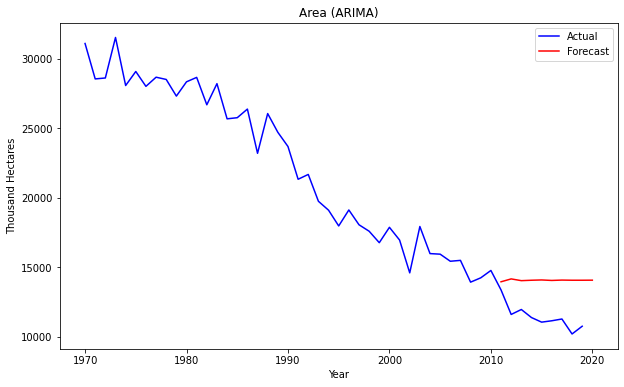

In [59]:
plt.plot(indexedDataset, color="blue", label= "Actual")
plt.plot(predicted_arima,color='red', label= "Forecast")
plt.title("Area (ARIMA)")
plt.xlabel('Year')
plt.ylabel('Thousand Hectares')
plt.legend(loc="upper right")

In [60]:
def error(y_true, y_pred):
    mad = np.mean(abs((y_true-y_pred)))
    MSE = np.mean(np.square((y_true-y_pred)))
    RMSE = np.sqrt(MSE)
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('MAD: %.2f  \nRMSE: %.2f \nMAPE: %.2f'% (mad,RMSE,MAPE))

In [61]:
error(test_df["Area"],predicted_arima)

MAD: 2645.09  
RMSE: 2783.14 
MAPE: 23.80


In [62]:
print(predicted_arima.head())

2011-01-01    13957.246347
2012-01-01    14164.603340
2013-01-01    14038.619779
2014-01-01    14068.277048
2015-01-01    14088.823942
Freq: AS-JAN, Name: predicted_mean, dtype: float64


## SARIMA MODEL

In [63]:
sarima_model = sm.tsa.statespace.SARIMAX(train_df, trend='t', order=(3,1,1)).fit()
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   Area   No. Observations:                   40
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -334.014
Date:                Wed, 23 Nov 2022   AIC                            680.029
Time:                        16:01:52   BIC                            690.010
Sample:                    01-01-1970   HQIC                           683.610
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -26.3599     14.687     -1.795      0.073     -55.146       2.426
ar.L1         -0.6726      0.407     -1.652      0.098      -1.470       0.125
ar.L2         -0.0777      0.219     -0.355      0.7

In [64]:
start_index = length_train+1
end_index = length
predicted_sarima = sarima_model.predict(start = start_index, end= end_index, typ="labels") 
print(predicted_sarima.head())

2011-01-01    12660.757142
2012-01-01    12219.772803
2013-01-01    11337.265185
2014-01-01    10681.286649
2015-01-01     9939.438783
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [65]:
# predicted_sarima.to_excel('predicted_sarima1.xlsx')

In [66]:
error(test_df["Area"],predicted_sarima)

MAD: 1694.36  
RMSE: 2054.73 
MAPE: 15.36


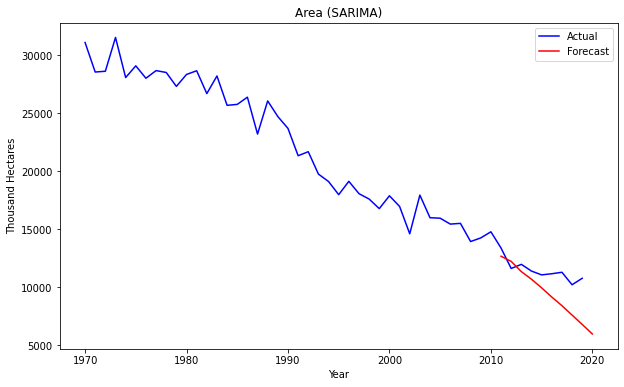

In [67]:
plt.plot(indexedDataset, color="blue", label= "Actual")
plt.plot(predicted_sarima,color='red', label= "Forecast")
plt.title("Area (SARIMA)")
plt.xlabel('Year')
plt.ylabel('Thousand Hectares')
plt.legend(loc="upper right")

## Simple Exponential Smoothing (SES)

In [32]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
start_index = 1
end_index = length+20
predicted_ses = SimpleExpSmoothing(test_df['Area']).fit().predict(start = start_index, end= end_index)

In [33]:
error(test_df["Area"],predicted_ses)

MAD: 697.79  
RMSE: 891.12 
MAPE: 6.04


Text(0.5, 1.0, 'AREA (SARIMA)')

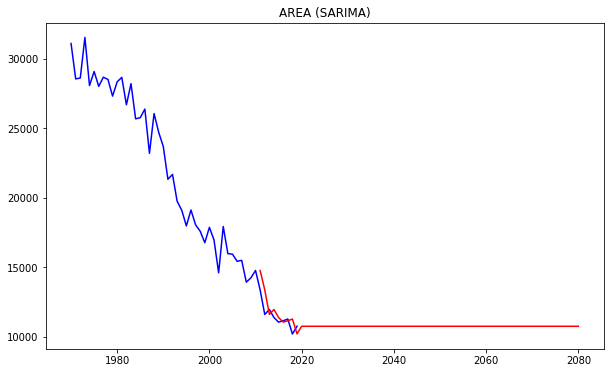

In [34]:
plt.plot(indexedDataset, color="blue")
plt.plot(predicted_ses,color='red')
plt.title("AREA (SARIMA)")